In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error

In [27]:
train_df = pd.read_csv('data/train.csv')
train_df.head()

C:\Users\User\AppData\Local\Temp\ipykernel_10424\1397079343.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('data/train.csv')


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [28]:
store_df = pd.read_csv('data/store.csv')
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [29]:
test_df = pd.read_csv('data/test.csv')
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [30]:
#merge training data with the store information with store data to the left
train = train_df.merge(store_df, on="Store", how="left")
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [31]:
#merge training data with the store information with store data to the left
test = test_df.merge(store_df, on="Store", how="left")
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


In [ ]:
def split_date(data):
    data = data.copy()
    #parse dates
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Day'] = data['Date'].dt.day
    data['Week'] = data['Date'].dt.isocalendar().week.astype(int)
    data['DayOfWeek'] = data['Date'].dt.dayofweek
    
    return data

train = split_date(train)
test = split_date(test)

In [33]:
train.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,Week
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,2.998341e+00,2014-04-11 01:30:42.846061824,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774,2.013832e+03,5.846762e+00,1.570279e+01,2.361551e+01
min,1.000000e+00,0.000000e+00,2013-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000,2.013000e+03,1.000000e+00,1.000000e+00,1.000000e+00
25%,2.800000e+02,1.000000e+00,2013-08-17 00:00:00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000,2.013000e+03,3.000000e+00,8.000000e+00,1.100000e+01
50%,5.580000e+02,3.000000e+00,2014-04-02 00:00:00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000,2.014000e+03,6.000000e+00,1.600000e+01,2.200000e+01
75%,8.380000e+02,5.000000e+00,2014-12-12 00:00:00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000,2.014000e+03,8.000000e+00,2.300000e+01,3.500000e+01
max,1.115000e+03,6.000000e+00,2015-07-31 00:00:00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000,2.015000e+03,1.200000e+01,3.100000e+01,5.200000e+01
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870,7.773960e-01,3.326097e+00,8.787638e+00,1.443338e+01


Data Cleaning

In [34]:
#remove closed stores (sales=0)
train = train[train["Open"] != 0].copy()
test = test[test["Open"] != 0].copy()

In [35]:
#check if current month is a Promo2 month
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        #get the list of promo months
        months = (row['PromoInterval'] or '').split(',')
        #check if the store has Promo2 and if the current month is in the list
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

In [36]:

#create promotion-related columns
def promo_cols(df):
    #calculate months since Promo2 was active
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) + \
                       (df.Week - df.Promo2SinceWeek) * 7 / 30.5
    #set to 0 if negative and fill NaNs. Only keep the value if promo2 is active for the store.
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    
    # check if the current month is a promotion month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

    #handle Competition Distance (missing = no competition). fill it with a very big val
    missing_comp = df['CompetitionDistance'].isnull().sum()
    max_distance = df['CompetitionDistance'].max()
    df['CompetitionDistance'] = df['CompetitionDistance'].fillna(max_distance * 2)
    return df


In [37]:
#calculate the duration of competition in months
def comp_months(df):
    #calc the number of months since the competition opened
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + \
                            (df.Month - df.CompetitionOpenSinceMonth)
    #ff the comp opened in the future, set the duration to 0. Fill any NaNs with 0.
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)
    return df

#sort data first
train = train.sort_values(['Store', 'Date']).reset_index(drop=True)
test = test.sort_values(['Store', 'Date']).reset_index(drop=True)

train = promo_cols(train)
train = comp_months(train)

test = promo_cols(test)
test = comp_months(test)

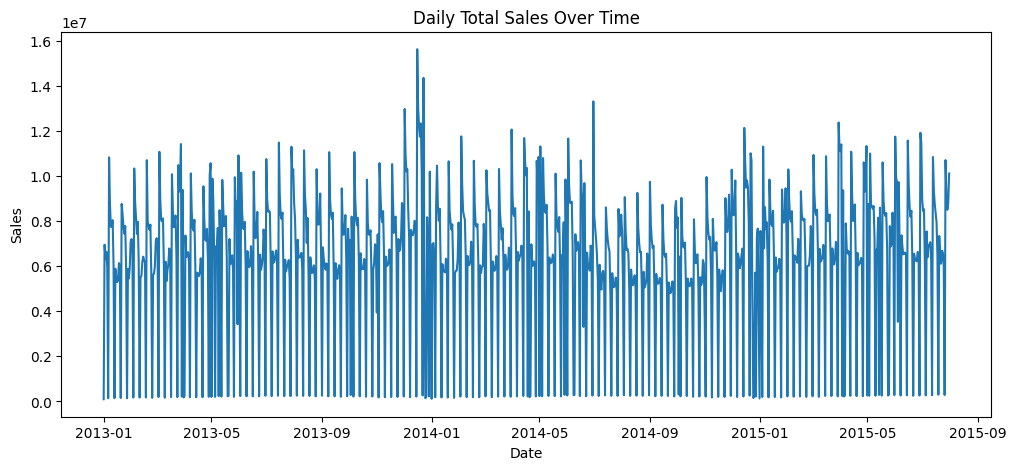

In [38]:
#overall sales distribution
train["year"] = train["Date"].dt.year
train["month"] = train["Date"].dt.month
train["dayofweek"] = train["Date"].dt.dayofweek

daily_sales = train.groupby("Date")["Sales"].sum().reset_index()

plt.figure(figsize=(12,5))
plt.plot(daily_sales["Date"], daily_sales["Sales"])
plt.title("Daily Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

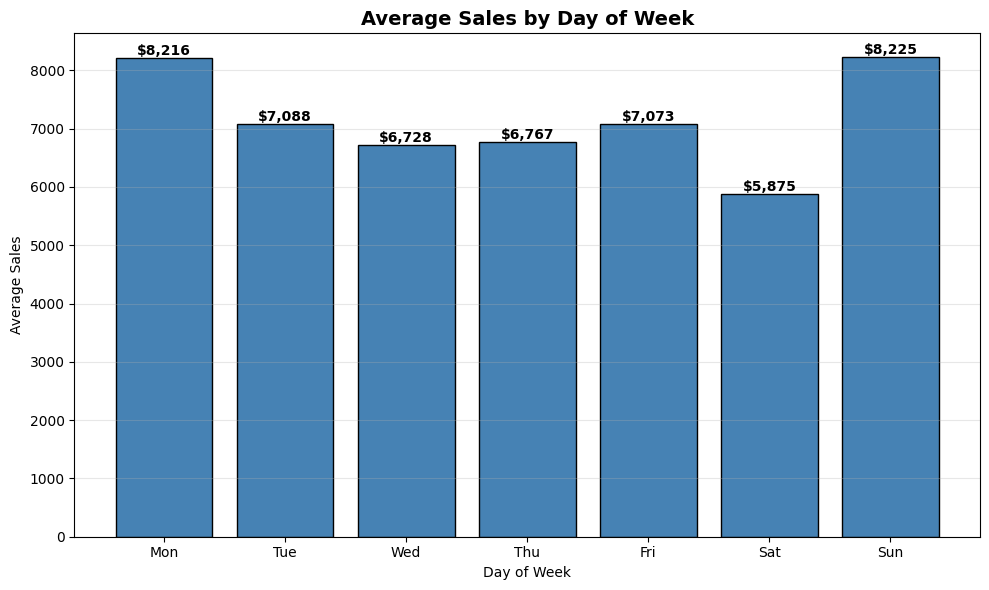

In [ ]:
plt.figure(figsize=(10, 6))
dow_sales = train.groupby('DayOfWeek')['Sales'].mean().sort_index()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.bar(range(7), dow_sales.values, color='steelblue', edgecolor='black')
plt.xticks(range(7), dow_labels)
plt.title('Average Sales by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.grid(True, alpha=0.3, axis='y')

#add values on bars
for i, v in enumerate(dow_sales.values):
    plt.text(i, v, f'${v:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('images/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

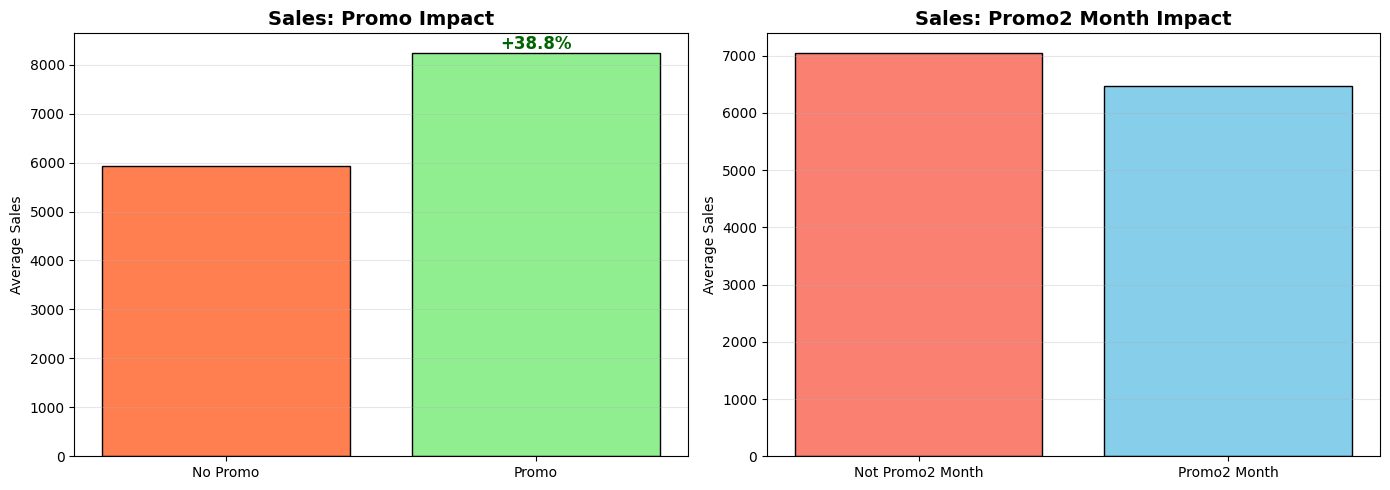

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#promo vs no promo
promo_sales = train.groupby('Promo')['Sales'].mean()
axes[0].bar(['No Promo', 'Promo'], promo_sales.values, color=['coral', 'lightgreen'], edgecolor='black')
axes[0].set_title('Sales: Promo Impact', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Average Sales')
axes[0].grid(True, alpha=0.3, axis='y')

increase = ((promo_sales[1] - promo_sales[0]) / promo_sales[0] * 100)
axes[0].text(1, promo_sales[1], f'+{increase:.1f}%', ha='center', va='bottom', 
             fontsize=12, fontweight='bold', color='darkgreen')

#promo2Month impact
promo2_sales = train.groupby('IsPromo2Month')['Sales'].mean()
axes[1].bar(['Not Promo2 Month', 'Promo2 Month'], promo2_sales.values, 
            color=['salmon', 'skyblue'], edgecolor='black')
axes[1].set_title('Sales: Promo2 Month Impact', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Average Sales')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('images/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

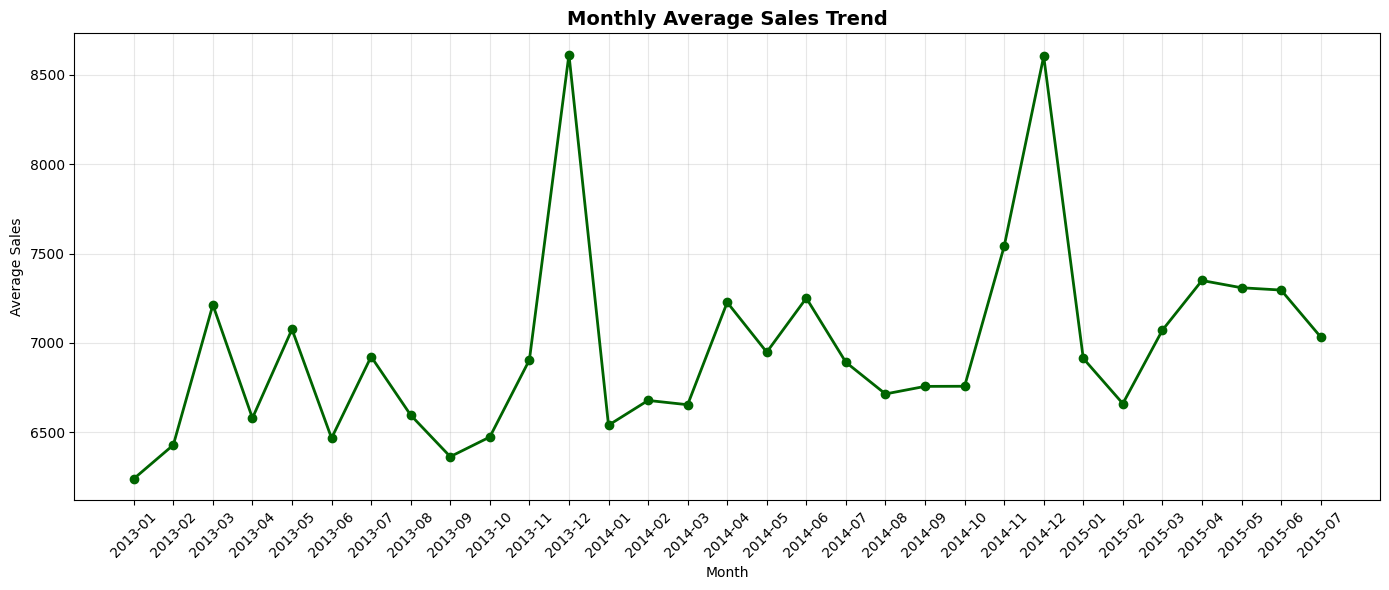

In [ ]:
plt.figure(figsize=(14, 6))

#monthly average sales
monthly_sales = train.groupby(train['Date'].dt.to_period('M'))['Sales'].mean()

plt.plot(monthly_sales.index.astype(str), monthly_sales.values, 
         marker='o', linewidth=2, markersize=6, color='darkgreen')
plt.title('Monthly Average Sales Trend', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

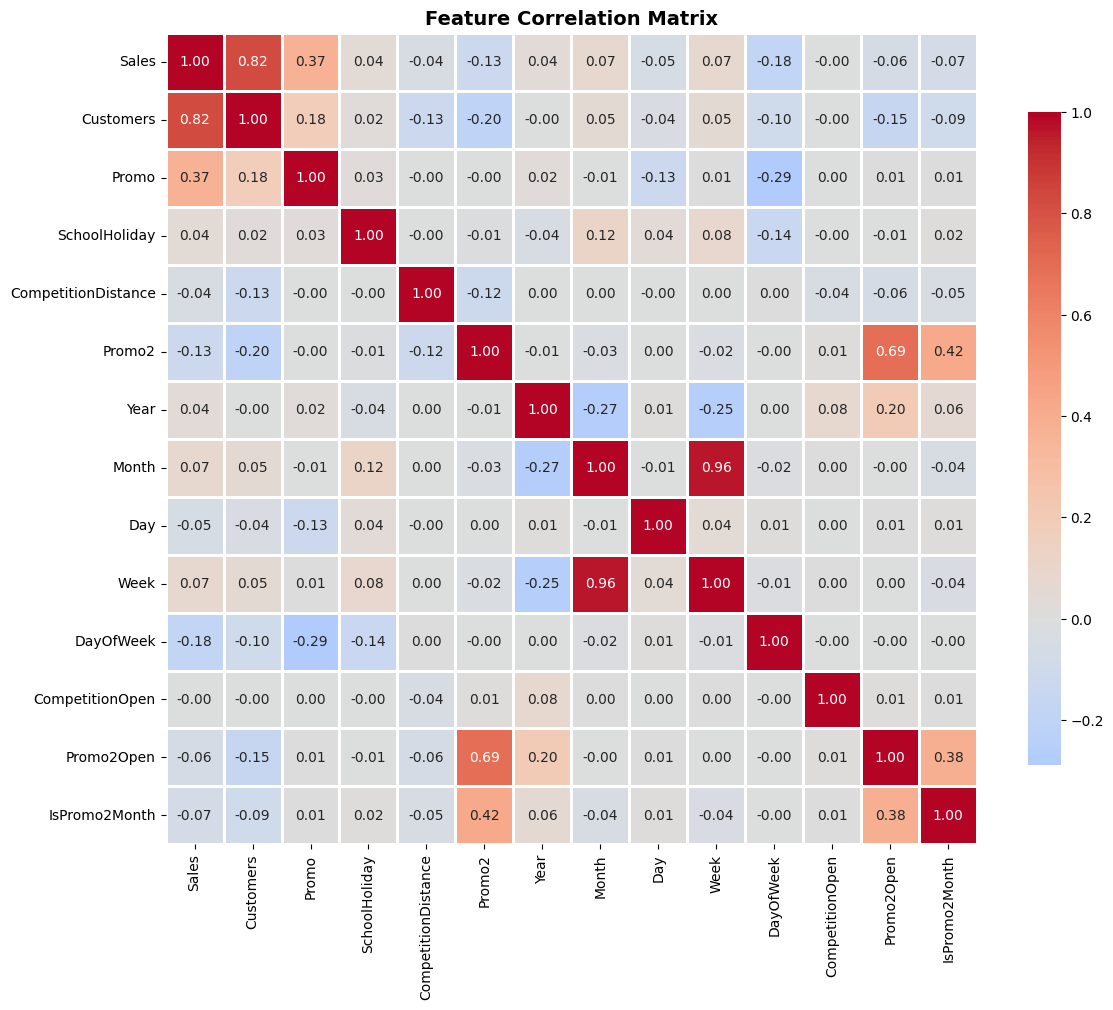

In [ ]:
plt.figure(figsize=(12, 10))

#feature correlation map
numeric_features = ['Sales', 'Customers', 'Promo', 'SchoolHoliday', 
                   'CompetitionDistance', 'Promo2', 'Year', 'Month', 'Day',
                   'Week', 'DayOfWeek', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month']

#calc correlation
corr = train[numeric_features].corr()

#create heatmap
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('images/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [43]:
#define target
target_col = 'Sales'

#encode StateHoliday
train['StateHoliday'] = train['StateHoliday'].map({0: 0, '0': 0, 'a': 1, 'b': 2, 'c': 3}).fillna(0).astype(int)
test['StateHoliday'] = test['StateHoliday'].map({0: 0, '0': 0, 'a': 1, 'b': 2, 'c': 3}).fillna(0).astype(int)

# one-hot encode
train = pd.get_dummies(train, columns=['StoreType', 'Assortment'], drop_first=False, dtype=int)
test = pd.get_dummies(test, columns=['StoreType', 'Assortment'], drop_first=False, dtype=int)

#define columns to EXCLUDE
exclude_cols = [
    'Sales',           
    'Customers',       
    'Date',            #already extracted
    'Open',            #filtered out
    'PromoInterval',   
    'CompetitionOpenSinceMonth',
    'CompetitionOpenSinceYear',
    'Promo2SinceWeek',
    'Promo2SinceYear',
    'Id'
]

In [44]:
input_cols = [col for col in train.columns 
              if col not in exclude_cols
              and train[col].dtype in ['int64', 'float64', 'int32', 'float32', 'bool', 'uint8']]

In [20]:
categorical_cols = ['StateHoliday', 'StoreType', 'Assortment']
#state holiday: 0, 'a', 'b', 'c' → 0, 1, 2, 3
train['StateHoliday'] = train['StateHoliday'].map({0: 0, '0': 0, 'a': 1, 'b': 2, 'c': 3})
test['StateHoliday'] = test['StateHoliday'].map({0: 0, '0': 0, 'a': 1, 'b': 2, 'c': 3})

#store type: a, b, c, d → use one-hot encoding
train = pd.get_dummies(train, columns=['StoreType', 'Assortment'], drop_first=False, dtype=int)
test = pd.get_dummies(test, columns=['StoreType', 'Assortment'], drop_first=False, dtype=int)

#update input_cols to include one-hot encoded columns
input_cols = [col for col in train.columns 
              if col not in ['Sales', 'Customers', 'Date', 'Open', 'CompDistBin']]


In [45]:
#time-based split
val_start = train['Date'].max() - pd.Timedelta(days=42)

train_data = train[train['Date'] < val_start]
val_data = train[train['Date'] >= val_start]

X_train = train_data[input_cols].fillna(0)
y_train = train_data[target_col]

X_val = val_data[input_cols].fillna(0)
y_val = val_data[target_col]

In [21]:
#time-based split (last 6 weeks as validation)
val_start_date = train['Date'].max() - pd.Timedelta(days=42)

train_data = train[train['Date'] < val_start_date]
val_data = train[train['Date'] >= val_start_date]

X_train = train_data[input_cols]
y_train = train_data[target_col]

X_val = val_data[input_cols]
y_val = val_data[target_col]

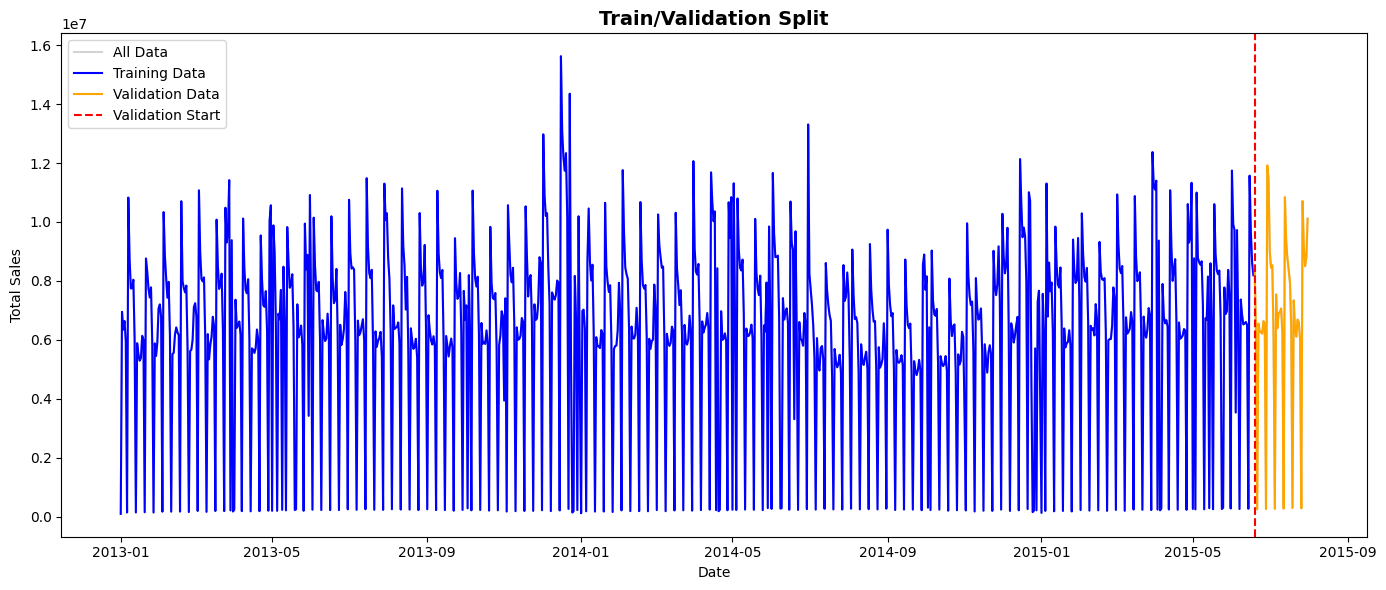

In [46]:
#plot total daily sales with train/validation split highlighted
daily_sales = train.groupby("Date")["Sales"].sum().reset_index()

plt.figure(figsize=(14,6))
plt.plot(daily_sales["Date"], daily_sales["Sales"], label="All Data", color="lightgray")

#highlight training period
train_sales = daily_sales[daily_sales["Date"] < val_start_date]
plt.plot(train_sales["Date"], train_sales["Sales"], label="Training Data", color="blue")

#highlight validation period
val_sales = daily_sales[daily_sales["Date"] >= val_start_date]
plt.plot(val_sales["Date"], val_sales["Sales"], label="Validation Data", color="orange")

#addd vertical line at the split point
plt.axvline(val_start_date, color="red", linestyle="--", label="Validation Start")

plt.title("Train/Validation Split", fontsize=14, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
baseline_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    verbose=False
)

#get baseline predictions
baseline_preds = baseline_model.predict(X_val)


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


In [65]:
from sklearn.metrics import mean_squared_error
#calc baseline metrics
baseline_rmse = np.sqrt(mean_squared_error(y_val, baseline_preds))
baseline_mae = mean_absolute_error(y_val, baseline_preds)
baseline_mape = np.mean(np.abs((y_val - baseline_preds) / y_val)) * 100

print(f"RMSE: {baseline_rmse:.4f}")
print(f"MAE: {baseline_mae:.4f}")
print(f"MAPE: {baseline_mape:.2f}%")


RMSE: 1363.4023
MAE: 997.4262
MAPE: 16.51%


In [47]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np


def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'random_state': 42,
        'n_jobs': -1,
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
    }

    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="rmse",
        verbose=False,
        early_stopping_rounds=50
    )

    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("best RMSE:", study.best_value)
print("best Params:", study.best_params)


#train final model with best param
best_params = study.best_params
best_params.update({
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'random_state': 42,
    'n_jobs': -1
})

final_model = xgb.XGBRegressor(**best_params)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    verbose=50,
    early_stopping_rounds=50
)


[I 2025-10-03 15:34:21,038] A new study created in memory with name: no-name-8ed697d2-4baa-4187-a820-4af38e0c2ba3
  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 0. Best value: 968.76:   2%|▏         | 1/50 [00:25<20:41, 25.33s/it]

[I 2025-10-03 15:34:46,368] Trial 0 finished with value: 968.7600313011783 and parameters: {'max_depth': 10, 'learning_rate': 0.05356975718593859, 'n_estimators': 960, 'subsample': 0.6533223044777963, 'colsample_bytree': 0.542869207671836, 'min_child_weight': 17, 'gamma': 3.7539903858319867, 'reg_alpha': 9.414920259406328, 'reg_lambda': 1.5670980162229242}. Best is trial 0 with value: 968.7600313011783.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 0. Best value: 968.76:   4%|▍         | 2/50 [00:36<13:45, 17.21s/it]

[I 2025-10-03 15:34:57,889] Trial 1 finished with value: 1013.4842759014049 and parameters: {'max_depth': 12, 'learning_rate': 0.27656566609553096, 'n_estimators': 349, 'subsample': 0.618243710514637, 'colsample_bytree': 0.6458509056591335, 'min_child_weight': 20, 'gamma': 2.5938616688021647, 'reg_alpha': 0.3517527162451306, 'reg_lambda': 8.968167638317828}. Best is trial 0 with value: 968.7600313011783.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 0. Best value: 968.76:   6%|▌         | 3/50 [00:43<09:42, 12.39s/it]

[I 2025-10-03 15:35:04,552] Trial 2 finished with value: 1392.3459708438647 and parameters: {'max_depth': 5, 'learning_rate': 0.1341303706303553, 'n_estimators': 397, 'subsample': 0.8533515187573473, 'colsample_bytree': 0.5121783868594503, 'min_child_weight': 18, 'gamma': 1.26833881309161, 'reg_alpha': 6.37070623644914, 'reg_lambda': 1.5433325493588557}. Best is trial 0 with value: 968.7600313011783.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 0. Best value: 968.76:   8%|▊         | 4/50 [00:59<10:40, 13.93s/it]

[I 2025-10-03 15:35:20,847] Trial 3 finished with value: 1541.20659886356 and parameters: {'max_depth': 10, 'learning_rate': 0.011675074499945322, 'n_estimators': 603, 'subsample': 0.8633999899908191, 'colsample_bytree': 0.785456312380204, 'min_child_weight': 10, 'gamma': 4.6598174603655504, 'reg_alpha': 0.23951930267641086, 'reg_lambda': 6.721217883635376}. Best is trial 0 with value: 968.7600313011783.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 0. Best value: 968.76:  10%|█         | 5/50 [01:09<09:18, 12.40s/it]

[I 2025-10-03 15:35:30,538] Trial 4 finished with value: 1026.0931429355642 and parameters: {'max_depth': 9, 'learning_rate': 0.12103225334489204, 'n_estimators': 387, 'subsample': 0.6814419791997398, 'colsample_bytree': 0.5334476814953328, 'min_child_weight': 1, 'gamma': 1.5177099818053597, 'reg_alpha': 1.53897062664478, 'reg_lambda': 6.378223291778125}. Best is trial 0 with value: 968.7600313011783.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 0. Best value: 968.76:  12%|█▏        | 6/50 [01:24<09:44, 13.28s/it]

[I 2025-10-03 15:35:45,530] Trial 5 finished with value: 1871.0517207582332 and parameters: {'max_depth': 7, 'learning_rate': 0.01430404916602088, 'n_estimators': 582, 'subsample': 0.5596284416384437, 'colsample_bytree': 0.6351597978787262, 'min_child_weight': 4, 'gamma': 2.9398911900856692, 'reg_alpha': 5.4147269202619155, 'reg_lambda': 9.686709624845612}. Best is trial 0 with value: 968.7600313011783.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 0. Best value: 968.76:  14%|█▍        | 7/50 [01:29<07:38, 10.67s/it]

[I 2025-10-03 15:35:50,809] Trial 6 finished with value: 2500.2652684087807 and parameters: {'max_depth': 4, 'learning_rate': 0.014146761828276976, 'n_estimators': 226, 'subsample': 0.505389074847829, 'colsample_bytree': 0.5710882334036209, 'min_child_weight': 19, 'gamma': 0.6651678652087856, 'reg_alpha': 5.0737794717409015, 'reg_lambda': 0.7991054453683988}. Best is trial 0 with value: 968.7600313011783.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 0. Best value: 968.76:  16%|█▌        | 8/50 [01:49<09:31, 13.62s/it]

[I 2025-10-03 15:36:10,739] Trial 7 finished with value: 990.8722553171033 and parameters: {'max_depth': 9, 'learning_rate': 0.054333161130884045, 'n_estimators': 785, 'subsample': 0.7594933626695859, 'colsample_bytree': 0.878435482676726, 'min_child_weight': 19, 'gamma': 0.19702406825150398, 'reg_alpha': 9.625217803746871, 'reg_lambda': 9.895765153322756}. Best is trial 0 with value: 968.7600313011783.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 0. Best value: 968.76:  18%|█▊        | 9/50 [02:02<09:13, 13.50s/it]

[I 2025-10-03 15:36:23,987] Trial 8 finished with value: 1616.0625806762398 and parameters: {'max_depth': 5, 'learning_rate': 0.05397044370135743, 'n_estimators': 590, 'subsample': 0.5458472982959124, 'colsample_bytree': 0.6107248335764421, 'min_child_weight': 18, 'gamma': 4.5275047993705915, 'reg_alpha': 5.315302900895756, 'reg_lambda': 0.914011048468043}. Best is trial 0 with value: 968.7600313011783.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 0. Best value: 968.76:  20%|██        | 10/50 [02:34<12:37, 18.93s/it]

[I 2025-10-03 15:36:55,073] Trial 9 finished with value: 977.8637400767694 and parameters: {'max_depth': 12, 'learning_rate': 0.05846824504693067, 'n_estimators': 805, 'subsample': 0.6201203632790452, 'colsample_bytree': 0.6582263328943136, 'min_child_weight': 20, 'gamma': 2.6965401030830254, 'reg_alpha': 6.555622148097706, 'reg_lambda': 9.973060253599453}. Best is trial 0 with value: 968.7600313011783.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 0. Best value: 968.76:  22%|██▏       | 11/50 [02:57<13:12, 20.33s/it]

[I 2025-10-03 15:37:18,574] Trial 10 finished with value: 1234.0987503830245 and parameters: {'max_depth': 7, 'learning_rate': 0.026666875088740088, 'n_estimators': 999, 'subsample': 0.9908925188011783, 'colsample_bytree': 0.9652908704070006, 'min_child_weight': 13, 'gamma': 3.792452566211926, 'reg_alpha': 9.934085568025704, 'reg_lambda': 3.6373703005169484}. Best is trial 0 with value: 968.7600313011783.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 11. Best value: 953.642:  24%|██▍       | 12/50 [03:43<17:47, 28.08s/it]

[I 2025-10-03 15:38:04,385] Trial 11 finished with value: 953.6424603272498 and parameters: {'max_depth': 12, 'learning_rate': 0.034868881377685755, 'n_estimators': 984, 'subsample': 0.6730196310046245, 'colsample_bytree': 0.7225567265370229, 'min_child_weight': 14, 'gamma': 3.502738784309094, 'reg_alpha': 7.737094622332128, 'reg_lambda': 3.52750719006979}. Best is trial 11 with value: 953.6424603272498.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 11. Best value: 953.642:  26%|██▌       | 13/50 [04:19<18:53, 30.64s/it]

[I 2025-10-03 15:38:40,900] Trial 12 finished with value: 995.1371953367259 and parameters: {'max_depth': 11, 'learning_rate': 0.028069067258078593, 'n_estimators': 957, 'subsample': 0.737744947402112, 'colsample_bytree': 0.7386507229336227, 'min_child_weight': 13, 'gamma': 3.642961248776443, 'reg_alpha': 8.09911369189631, 'reg_lambda': 3.263222728387162}. Best is trial 11 with value: 953.6424603272498.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 11. Best value: 953.642:  28%|██▊       | 14/50 [04:53<18:54, 31.53s/it]

[I 2025-10-03 15:39:14,489] Trial 13 finished with value: 988.7099896010949 and parameters: {'max_depth': 11, 'learning_rate': 0.029154886428054933, 'n_estimators': 860, 'subsample': 0.7179548130562936, 'colsample_bytree': 0.741353047774018, 'min_child_weight': 14, 'gamma': 3.651815291969782, 'reg_alpha': 8.686039609230969, 'reg_lambda': 2.736524449911742}. Best is trial 11 with value: 953.6424603272498.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 14. Best value: 946.083:  30%|███       | 15/50 [05:20<17:38, 30.25s/it]

[I 2025-10-03 15:39:41,776] Trial 14 finished with value: 946.0825504278056 and parameters: {'max_depth': 10, 'learning_rate': 0.08772592229934574, 'n_estimators': 884, 'subsample': 0.6512485597114672, 'colsample_bytree': 0.8168825118190859, 'min_child_weight': 8, 'gamma': 1.8833288580210539, 'reg_alpha': 7.351148012530739, 'reg_lambda': 4.79658261287533}. Best is trial 14 with value: 946.0825504278056.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 14. Best value: 946.083:  32%|███▏      | 16/50 [05:58<18:29, 32.64s/it]

[I 2025-10-03 15:40:19,975] Trial 15 finished with value: 969.1176888150122 and parameters: {'max_depth': 12, 'learning_rate': 0.09085492232642231, 'n_estimators': 703, 'subsample': 0.8179583110590349, 'colsample_bytree': 0.8326450360463359, 'min_child_weight': 8, 'gamma': 2.0037089384794076, 'reg_alpha': 3.1236613691903328, 'reg_lambda': 5.118424791852585}. Best is trial 14 with value: 946.0825504278056.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  34%|███▍      | 17/50 [06:24<16:50, 30.63s/it]

[I 2025-10-03 15:40:45,925] Trial 16 finished with value: 932.0271807789481 and parameters: {'max_depth': 8, 'learning_rate': 0.1590271677026763, 'n_estimators': 879, 'subsample': 0.7817086181942133, 'colsample_bytree': 0.9190125224482855, 'min_child_weight': 6, 'gamma': 1.959126910612303, 'reg_alpha': 7.466544271915279, 'reg_lambda': 4.8598310285233275}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  36%|███▌      | 18/50 [06:48<15:11, 28.48s/it]

[I 2025-10-03 15:41:09,409] Trial 17 finished with value: 1023.1222652116886 and parameters: {'max_depth': 8, 'learning_rate': 0.2487151745185485, 'n_estimators': 875, 'subsample': 0.9388569736530836, 'colsample_bytree': 0.9842262508930097, 'min_child_weight': 6, 'gamma': 1.9183729614525304, 'reg_alpha': 3.8234593612254, 'reg_lambda': 5.076591844517406}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  38%|███▊      | 19/50 [07:07<13:13, 25.59s/it]

[I 2025-10-03 15:41:28,260] Trial 18 finished with value: 986.4099405557896 and parameters: {'max_depth': 7, 'learning_rate': 0.15924505830420332, 'n_estimators': 678, 'subsample': 0.7850820639129449, 'colsample_bytree': 0.9132827234599652, 'min_child_weight': 4, 'gamma': 0.8282684878216087, 'reg_alpha': 6.947455931815971, 'reg_lambda': 7.204940215513172}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  40%|████      | 20/50 [07:27<12:00, 24.02s/it]

[I 2025-10-03 15:41:48,617] Trial 19 finished with value: 966.7060365525722 and parameters: {'max_depth': 8, 'learning_rate': 0.19058176772375401, 'n_estimators': 721, 'subsample': 0.8933575331007947, 'colsample_bytree': 0.8203500368270821, 'min_child_weight': 9, 'gamma': 1.8438423829276254, 'reg_alpha': 3.8921167101230467, 'reg_lambda': 8.098627435454912}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  42%|████▏     | 21/50 [07:41<10:06, 20.90s/it]

[I 2025-10-03 15:42:02,258] Trial 20 finished with value: 995.1529721729863 and parameters: {'max_depth': 9, 'learning_rate': 0.07938232293125454, 'n_estimators': 490, 'subsample': 0.8108194080384359, 'colsample_bytree': 0.9140237161644296, 'min_child_weight': 7, 'gamma': 2.1576276605336244, 'reg_alpha': 7.476364340554638, 'reg_lambda': 5.774356381658925}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  44%|████▍     | 22/50 [08:17<11:53, 25.50s/it]

[I 2025-10-03 15:42:38,473] Trial 21 finished with value: 958.458978864891 and parameters: {'max_depth': 11, 'learning_rate': 0.03775588204388294, 'n_estimators': 915, 'subsample': 0.6933130307154272, 'colsample_bytree': 0.7131826455529521, 'min_child_weight': 11, 'gamma': 3.21213784431289, 'reg_alpha': 8.649643705815802, 'reg_lambda': 3.880606220820324}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  46%|████▌     | 23/50 [08:45<11:48, 26.24s/it]

[I 2025-10-03 15:43:06,432] Trial 22 finished with value: 955.9462634350432 and parameters: {'max_depth': 10, 'learning_rate': 0.10200716784620042, 'n_estimators': 841, 'subsample': 0.6250353990522844, 'colsample_bytree': 0.8568053451233343, 'min_child_weight': 5, 'gamma': 1.328250865335848, 'reg_alpha': 7.905808070130104, 'reg_lambda': 4.178335487100262}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  48%|████▊     | 24/50 [09:23<12:56, 29.88s/it]

[I 2025-10-03 15:43:44,795] Trial 23 finished with value: 967.1596609323663 and parameters: {'max_depth': 11, 'learning_rate': 0.07452768453924775, 'n_estimators': 771, 'subsample': 0.5726995222286091, 'colsample_bytree': 0.788824587635244, 'min_child_weight': 2, 'gamma': 2.3877102034079614, 'reg_alpha': 6.080321430740463, 'reg_lambda': 2.5088963997605673}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  50%|█████     | 25/50 [09:47<11:37, 27.89s/it]

[I 2025-10-03 15:44:08,046] Trial 24 finished with value: 1294.1062911234148 and parameters: {'max_depth': 6, 'learning_rate': 0.03988637752481114, 'n_estimators': 906, 'subsample': 0.6881224893599498, 'colsample_bytree': 0.699880767247988, 'min_child_weight': 15, 'gamma': 4.267432706336319, 'reg_alpha': 7.360979112836951, 'reg_lambda': 4.6327064019406965}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  52%|█████▏    | 26/50 [10:07<10:18, 25.78s/it]

[I 2025-10-03 15:44:28,895] Trial 25 finished with value: 955.8072214064249 and parameters: {'max_depth': 9, 'learning_rate': 0.1926425575250349, 'n_estimators': 996, 'subsample': 0.7463385326929288, 'colsample_bytree': 0.9079538732424346, 'min_child_weight': 11, 'gamma': 3.130087920746295, 'reg_alpha': 8.387031733170083, 'reg_lambda': 5.551677333379574}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  54%|█████▍    | 27/50 [10:38<10:24, 27.15s/it]

[I 2025-10-03 15:44:59,240] Trial 26 finished with value: 1069.7688524720722 and parameters: {'max_depth': 10, 'learning_rate': 0.018712941674790543, 'n_estimators': 914, 'subsample': 0.6435674836803538, 'colsample_bytree': 0.9486595384678411, 'min_child_weight': 7, 'gamma': 0.9137462845193599, 'reg_alpha': 5.905642720906437, 'reg_lambda': 2.59755489200114}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  56%|█████▌    | 28/50 [11:03<09:42, 26.50s/it]

[I 2025-10-03 15:45:24,220] Trial 27 finished with value: 963.6855377874524 and parameters: {'max_depth': 8, 'learning_rate': 0.11237881537586375, 'n_estimators': 836, 'subsample': 0.7812738400064703, 'colsample_bytree': 0.8016005218431306, 'min_child_weight': 9, 'gamma': 2.411339317331095, 'reg_alpha': 7.214067812639732, 'reg_lambda': 4.414350526467642}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  58%|█████▊    | 29/50 [11:31<09:25, 26.92s/it]

[I 2025-10-03 15:45:52,123] Trial 28 finished with value: 992.9121808821413 and parameters: {'max_depth': 11, 'learning_rate': 0.04003486619082758, 'n_estimators': 654, 'subsample': 0.7117716372939064, 'colsample_bytree': 0.8707195050444567, 'min_child_weight': 16, 'gamma': 1.5357090645697795, 'reg_alpha': 4.510926564578494, 'reg_lambda': 7.332285294228039}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  60%|██████    | 30/50 [13:33<18:29, 55.49s/it]

[I 2025-10-03 15:47:54,271] Trial 29 finished with value: 971.1782924318069 and parameters: {'max_depth': 10, 'learning_rate': 0.0720420763067101, 'n_estimators': 751, 'subsample': 0.5933143151134532, 'colsample_bytree': 0.7628727487829382, 'min_child_weight': 3, 'gamma': 3.9787091264007826, 'reg_alpha': 9.274849124989233, 'reg_lambda': 6.05798639567708}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  62%|██████▏   | 31/50 [13:52<14:07, 44.59s/it]

[I 2025-10-03 15:48:13,422] Trial 30 finished with value: 969.2308188721613 and parameters: {'max_depth': 12, 'learning_rate': 0.1461965513812166, 'n_estimators': 967, 'subsample': 0.6520624574606521, 'colsample_bytree': 0.7019022417118689, 'min_child_weight': 12, 'gamma': 4.929346646123489, 'reg_alpha': 7.826250906685562, 'reg_lambda': 2.0575536902413774}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  64%|██████▍   | 32/50 [14:14<11:19, 37.75s/it]

[I 2025-10-03 15:48:35,227] Trial 31 finished with value: 953.2319836509039 and parameters: {'max_depth': 9, 'learning_rate': 0.18775038128024538, 'n_estimators': 986, 'subsample': 0.7566327490337085, 'colsample_bytree': 0.9260213689100665, 'min_child_weight': 11, 'gamma': 3.1424865563500424, 'reg_alpha': 8.679829764484973, 'reg_lambda': 5.277918581382169}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  66%|██████▌   | 33/50 [14:28<08:43, 30.78s/it]

[I 2025-10-03 15:48:49,753] Trial 32 finished with value: 1001.0702057708736 and parameters: {'max_depth': 9, 'learning_rate': 0.23079233240245647, 'n_estimators': 949, 'subsample': 0.6616098181713784, 'colsample_bytree': 0.947386590222507, 'min_child_weight': 9, 'gamma': 3.3277741187451415, 'reg_alpha': 9.061271406577898, 'reg_lambda': 3.261138226967553}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  68%|██████▊   | 34/50 [14:59<08:10, 30.65s/it]

[I 2025-10-03 15:49:20,096] Trial 33 finished with value: 962.21512295829 and parameters: {'max_depth': 8, 'learning_rate': 0.196371258049761, 'n_estimators': 893, 'subsample': 0.7839367417782427, 'colsample_bytree': 0.8399368965021567, 'min_child_weight': 7, 'gamma': 2.825895283824088, 'reg_alpha': 6.8145247881474, 'reg_lambda': 5.348558451877156}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  70%|███████   | 35/50 [15:26<07:24, 29.66s/it]

[I 2025-10-03 15:49:47,437] Trial 34 finished with value: 957.6359992809029 and parameters: {'max_depth': 10, 'learning_rate': 0.15079428927262023, 'n_estimators': 943, 'subsample': 0.8220584660209908, 'colsample_bytree': 0.9060801377261878, 'min_child_weight': 10, 'gamma': 3.44008513851164, 'reg_alpha': 8.868853166701923, 'reg_lambda': 4.652619725560528}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  72%|███████▏  | 36/50 [15:43<06:02, 25.89s/it]

[I 2025-10-03 15:50:04,544] Trial 35 finished with value: 1052.0712034354704 and parameters: {'max_depth': 7, 'learning_rate': 0.2904490814711669, 'n_estimators': 843, 'subsample': 0.7296265973813095, 'colsample_bytree': 0.9985020303641434, 'min_child_weight': 12, 'gamma': 2.238880790826464, 'reg_alpha': 7.800243012353123, 'reg_lambda': 6.656985271043162}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  74%|███████▍  | 37/50 [16:13<05:54, 27.27s/it]

[I 2025-10-03 15:50:35,029] Trial 36 finished with value: 972.0249881893849 and parameters: {'max_depth': 10, 'learning_rate': 0.11727238414469697, 'n_estimators': 993, 'subsample': 0.8582586648527994, 'colsample_bytree': 0.7671688976831019, 'min_child_weight': 16, 'gamma': 1.7182665331481508, 'reg_alpha': 6.366335174155067, 'reg_lambda': 0.14768870700432357}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  76%|███████▌  | 38/50 [16:31<04:50, 24.25s/it]

[I 2025-10-03 15:50:52,228] Trial 37 finished with value: 1363.436187187898 and parameters: {'max_depth': 9, 'learning_rate': 0.02155593899240535, 'n_estimators': 507, 'subsample': 0.6680984948838172, 'colsample_bytree': 0.6758555765016022, 'min_child_weight': 5, 'gamma': 3.0366975382257353, 'reg_alpha': 2.408671563621545, 'reg_lambda': 3.7200009483062457}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  78%|███████▊  | 39/50 [16:37<03:28, 18.93s/it]

[I 2025-10-03 15:50:58,749] Trial 38 finished with value: 1516.6069863036616 and parameters: {'max_depth': 6, 'learning_rate': 0.09578691660900247, 'n_estimators': 226, 'subsample': 0.8904391054941726, 'colsample_bytree': 0.8706051806582948, 'min_child_weight': 8, 'gamma': 2.5572689336824457, 'reg_alpha': 9.566098951011229, 'reg_lambda': 5.854356613263111}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  80%|████████  | 40/50 [17:04<03:31, 21.16s/it]

[I 2025-10-03 15:51:25,116] Trial 39 finished with value: 1022.1307539125884 and parameters: {'max_depth': 8, 'learning_rate': 0.06557958784771759, 'n_estimators': 812, 'subsample': 0.595645606095347, 'colsample_bytree': 0.8101623341994366, 'min_child_weight': 13, 'gamma': 4.175344396689719, 'reg_alpha': 5.8015502426336845, 'reg_lambda': 4.768198364745226}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  82%|████████▏ | 41/50 [17:55<04:31, 30.11s/it]

[I 2025-10-03 15:52:16,113] Trial 40 finished with value: 1001.2144460198665 and parameters: {'max_depth': 12, 'learning_rate': 0.04332686505619337, 'n_estimators': 929, 'subsample': 0.7623089955393608, 'colsample_bytree': 0.9278251692260896, 'min_child_weight': 10, 'gamma': 1.1644888736112156, 'reg_alpha': 7.413493972306055, 'reg_lambda': 6.423700481972112}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  84%|████████▍ | 42/50 [18:13<03:31, 26.49s/it]

[I 2025-10-03 15:52:34,144] Trial 41 finished with value: 1005.8753991251064 and parameters: {'max_depth': 9, 'learning_rate': 0.1870217123671538, 'n_estimators': 975, 'subsample': 0.7060415199612515, 'colsample_bytree': 0.8915855063365639, 'min_child_weight': 11, 'gamma': 2.9796400469322992, 'reg_alpha': 8.33565671003768, 'reg_lambda': 5.440491648395062}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  86%|████████▌ | 43/50 [18:30<02:45, 23.68s/it]

[I 2025-10-03 15:52:51,258] Trial 42 finished with value: 1026.3673325106408 and parameters: {'max_depth': 9, 'learning_rate': 0.22321852711705198, 'n_estimators': 887, 'subsample': 0.7463234548211024, 'colsample_bytree': 0.9397257913267681, 'min_child_weight': 12, 'gamma': 2.711834231960492, 'reg_alpha': 8.341237227194132, 'reg_lambda': 4.222201924068493}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  88%|████████▊ | 44/50 [19:04<02:41, 26.84s/it]

[I 2025-10-03 15:53:25,497] Trial 43 finished with value: 960.4050467712793 and parameters: {'max_depth': 10, 'learning_rate': 0.12607788075550133, 'n_estimators': 1000, 'subsample': 0.7486370354359352, 'colsample_bytree': 0.9661320542349857, 'min_child_weight': 14, 'gamma': 3.2117860674435637, 'reg_alpha': 9.952427104007851, 'reg_lambda': 7.266997752333687}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  90%|█████████ | 45/50 [19:36<02:21, 28.39s/it]

[I 2025-10-03 15:53:57,498] Trial 44 finished with value: 962.0166562987854 and parameters: {'max_depth': 8, 'learning_rate': 0.15672739570856964, 'n_estimators': 949, 'subsample': 0.5243679495135881, 'colsample_bytree': 0.8493759645395236, 'min_child_weight': 8, 'gamma': 3.499761176671377, 'reg_alpha': 8.427728876927848, 'reg_lambda': 5.69197181346825}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  92%|█████████▏| 46/50 [20:04<01:53, 28.34s/it]

[I 2025-10-03 15:54:25,730] Trial 45 finished with value: 1010.4467380375379 and parameters: {'max_depth': 9, 'learning_rate': 0.1770515460090988, 'n_estimators': 885, 'subsample': 0.8355445165436503, 'colsample_bytree': 0.8910889897929978, 'min_child_weight': 11, 'gamma': 3.0592895713248565, 'reg_alpha': 0.9977577486114946, 'reg_lambda': 3.1612907275351554}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  94%|█████████▍| 47/50 [20:23<01:16, 25.47s/it]

[I 2025-10-03 15:54:44,487] Trial 46 finished with value: 1046.664311895736 and parameters: {'max_depth': 11, 'learning_rate': 0.2480516674666121, 'n_estimators': 972, 'subsample': 0.7698438141776617, 'colsample_bytree': 0.7224305331917138, 'min_child_weight': 15, 'gamma': 3.9673213131504386, 'reg_alpha': 6.6269448543810645, 'reg_lambda': 5.00527135524486}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  96%|█████████▌| 48/50 [20:48<00:50, 25.30s/it]

[I 2025-10-03 15:55:09,406] Trial 47 finished with value: 1065.2887253598449 and parameters: {'max_depth': 9, 'learning_rate': 0.033799327396769864, 'n_estimators': 801, 'subsample': 0.7247820443792178, 'colsample_bytree': 0.6024741968034497, 'min_child_weight': 6, 'gamma': 2.2348530412579657, 'reg_alpha': 9.265561274129768, 'reg_lambda': 6.235542633105235}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027:  98%|█████████▊| 49/50 [21:17<00:26, 26.56s/it]

[I 2025-10-03 15:55:38,884] Trial 48 finished with value: 1010.1254194281508 and parameters: {'max_depth': 6, 'learning_rate': 0.13319451259483944, 'n_estimators': 935, 'subsample': 0.633039107524376, 'colsample_bytree': 0.9711490178404031, 'min_child_weight': 10, 'gamma': 2.5994322285537113, 'reg_alpha': 7.00056309423168, 'reg_lambda': 1.6003013800292054}. Best is trial 16 with value: 932.0271807789481.


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Best trial: 16. Best value: 932.027: 100%|██████████| 50/50 [21:43<00:00, 26.08s/it]


[I 2025-10-03 15:56:04,984] Trial 49 finished with value: 1144.9091077971068 and parameters: {'max_depth': 7, 'learning_rate': 0.04805348024080908, 'n_estimators': 864, 'subsample': 0.8018826929995343, 'colsample_bytree': 0.5088492956860314, 'min_child_weight': 14, 'gamma': 1.6176989419370336, 'reg_alpha': 7.742745468982349, 'reg_lambda': 3.9737053933950204}. Best is trial 16 with value: 932.0271807789481.
best RMSE: 932.0271807789481
best Params: {'max_depth': 8, 'learning_rate': 0.1590271677026763, 'n_estimators': 879, 'subsample': 0.7817086181942133, 'colsample_bytree': 0.9190125224482855, 'min_child_weight': 6, 'gamma': 1.959126910612303, 'reg_alpha': 7.466544271915279, 'reg_lambda': 4.8598310285233275}
[0]	validation_0-rmse:2898.59063


c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\User\Documents\rossmann_sales\venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-rmse:1631.86472
[100]	validation_0-rmse:1262.16127
[150]	validation_0-rmse:1107.51251
[200]	validation_0-rmse:1047.45785
[250]	validation_0-rmse:1014.68249
[300]	validation_0-rmse:998.86047
[350]	validation_0-rmse:986.37670
[400]	validation_0-rmse:976.26502
[450]	validation_0-rmse:966.11941
[500]	validation_0-rmse:959.91148
[550]	validation_0-rmse:954.89892
[600]	validation_0-rmse:950.10185
[650]	validation_0-rmse:944.56333
[700]	validation_0-rmse:940.81857
[750]	validation_0-rmse:937.01342
[800]	validation_0-rmse:935.48963
[850]	validation_0-rmse:933.82084
[878]	validation_0-rmse:932.10668


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9190125224482855, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1.959126910612303,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1590271677026763,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=879, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])


In [52]:
val_preds = final_model.predict(X_val)

#calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
val_mae = mean_absolute_error(y_val, val_preds)
val_r2 = r2_score(y_val, val_preds)
val_mape = np.mean(np.abs((y_val - val_preds) / y_val)) * 100


print("VALIDATION SET PERFORMANCE (Last 6 Weeks) = ")
print(f"RMSE: {val_rmse:.4f}")
print(f"MAE: {val_mae:.4f}")
print(f"R² Score: {val_r2:.4f}")
print(f"MAPE: {val_mape:.2f}%")
print(f"Number of validation samples: {len(y_val)}")

VALIDATION SET PERFORMANCE (Last 6 Weeks) = 
RMSE: 932.0272
MAE: 651.2856
R² Score: 0.9063
MAPE: 10.10%
Number of validation samples: 41396


In [66]:
print("IMPROVEMENT")
rmse_improvement = ((baseline_rmse - val_rmse) / baseline_rmse) * 100
mae_improvement = ((baseline_mae - val_mae) / baseline_mae) * 100
mape_improvement = ((baseline_mape - val_mape) / baseline_mape) * 100

print(f"RMSE Improvement: {rmse_improvement:.2f}%")
print(f"MAE Improvement: {mae_improvement:.2f}%")
print(f"MAPE Improvement: {mape_improvement:.2f}%")

IMPROVEMENT
RMSE Improvement: 31.64%
MAE Improvement: 34.70%
MAPE Improvement: 38.82%


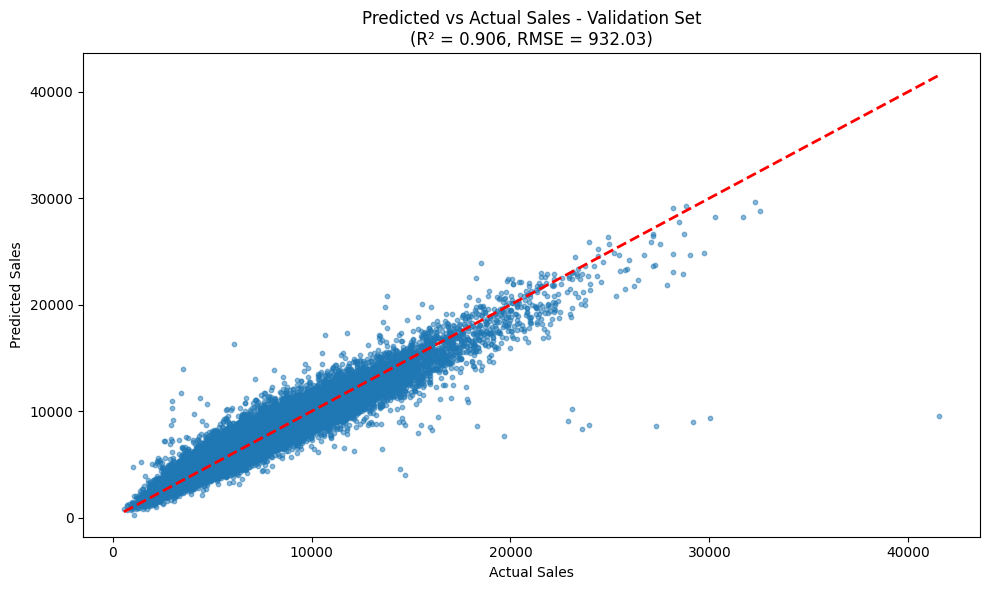

In [53]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, val_preds, alpha=0.5, s=10)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title(f"Predicted vs Actual Sales - Validation Set\n(R² = {val_r2:.3f}, RMSE = {val_rmse:.2f})")
plt.tight_layout()
plt.show()

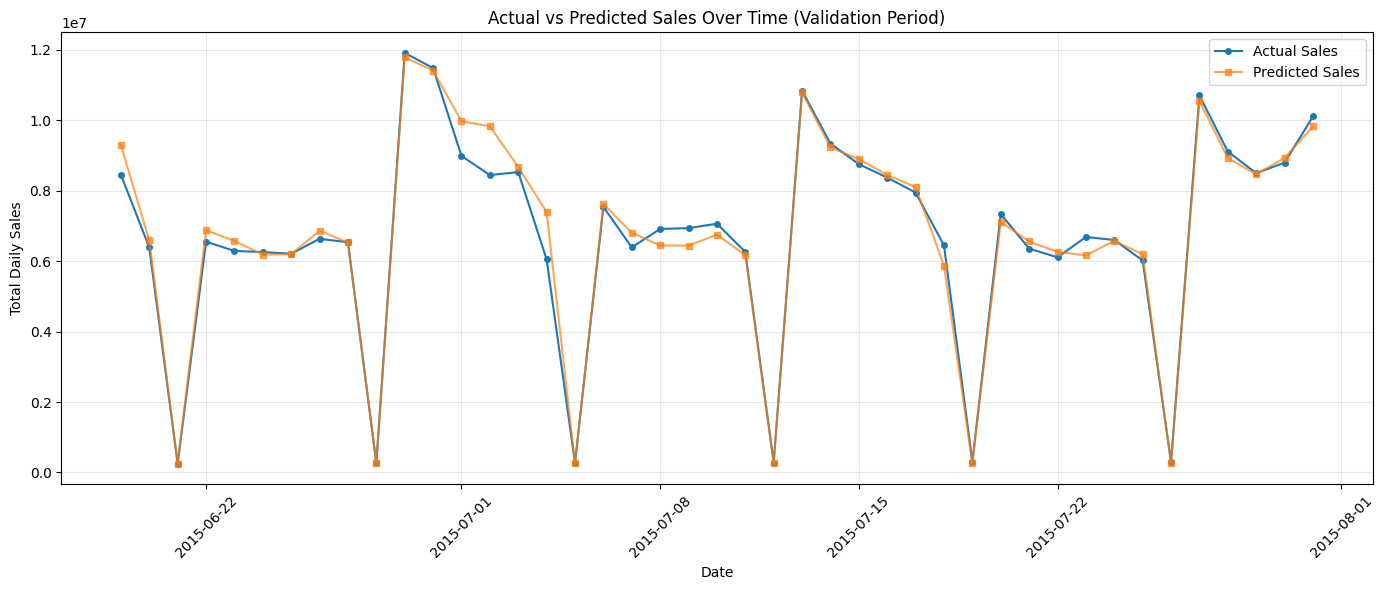

In [ ]:
#add predictions to validation data
val_data_with_preds = val_data.copy()
val_data_with_preds['Predictions'] = val_preds

#aggregate by date for visualization
daily_actual = val_data_with_preds.groupby('Date')['Sales'].sum().reset_index()
daily_pred = val_data_with_preds.groupby('Date')['Predictions'].sum().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(daily_actual['Date'], daily_actual['Sales'], label='Actual Sales', marker='o', markersize=4)
plt.plot(daily_pred['Date'], daily_pred['Predictions'], label='Predicted Sales', marker='s', markersize=4, alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Total Daily Sales')
plt.title('Actual vs Predicted Sales Over Time (Validation Period)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

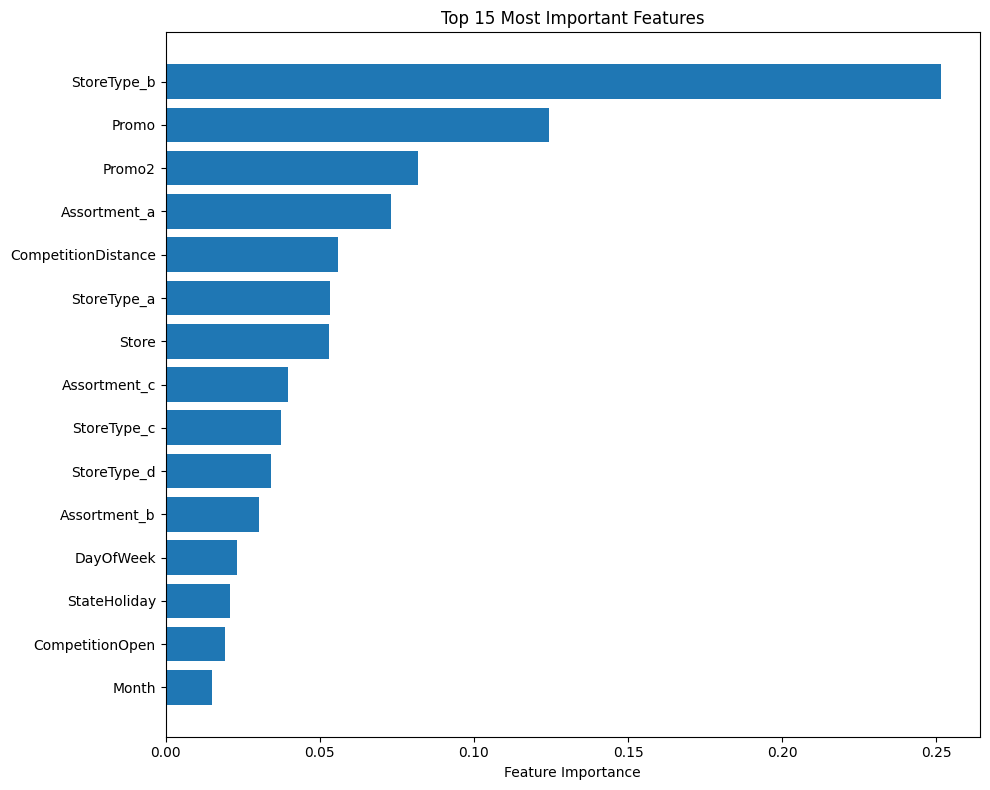


Top 10 Features by Importance:
            feature  importance
        StoreType_b    0.251556
              Promo    0.124190
             Promo2    0.081718
       Assortment_a    0.072989
CompetitionDistance    0.055985
        StoreType_a    0.053258
              Store    0.053030
       Assortment_c    0.039686
        StoreType_c    0.037539
        StoreType_d    0.034151


In [55]:
#get feature importance
importance = final_model.feature_importances_
feature_names = X_train.columns.tolist()

#create DataFrame and sort
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False).head(15)  # Top 15 features


plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importance_df)), feature_importance_df['importance'].values)
plt.yticks(range(len(feature_importance_df)), feature_importance_df['feature'].values)
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#print feature importance
print("\nTop 10 Features by Importance:")
print(feature_importance_df.head(10).to_string(index=False))

In [ ]:
test_open_indices = test_df[test_df['Open'] != 0].index

#ensure test set has the same one-hot encoded columns as training set
missing_cols = set(X_train.columns) - set(test.columns)
for col in missing_cols:
    test[col] = 0

#reorder test columns to match training columns
X_test = test[X_train.columns]

#generate predictions for open stores only
test_predictions = final_model.predict(X_test)

#create submission for ALL test data
submission = test_df[['Id']].copy()
submission['Sales'] = 0.0  # Initialize all with 0

#assign predictions to open stores
submission.loc[test_open_indices, 'Sales'] = test_predictions

#ensure no negative predictions
submission['Sales'] = submission['Sales'].clip(lower=0)

#round off sales to nearest integer
submission['Sales'] = submission['Sales'].round(0).astype(int)

#save to CSV
submission.to_csv('submission.csv', index=False)


In [61]:
import json

#save the model
final_model.save_model('rossmann_sales_model.json')